In [1]:
# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip install -U gensim  # Install gensim 4
    !nvidia-smi             # Check which GPU has been chosen for us
    !rm -rf logs
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r /content/drive/MyDrive/Uni/Magistrale/NLP/Project/data/ data
except:
    IN_COLAB = False

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Fri Dec 31 12:32:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |     

# Question Answering Project

## Data Preprocessing

### Imports

In [2]:
%load_ext tensorboard

import os
import requests
import zipfile
from tqdm import tqdm
import time
import random
import datetime
from IPython.display import display
from functools import partial

from typing import List, Dict, Callable, Sequence, Tuple

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import gensim
import gensim.downloader as gloader
assert int(gensim.__version__.split('.')[0]) >= 4, "Install gensim 4.x.x or above (pip install -U gensim)"

%matplotlib inline

BATCH_SIZE = 64

# Fix random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Dataset Analysis

We load the dataset and explore it.

In [3]:
TRAINING_FILE = os.path.join('data', 'training_set.json')

with open(TRAINING_FILE, 'r') as f:
    questions = json.load(f)

The training set contains 442 articles

On average, each articles contains 42.75 paragraphs...
	with a maximum of 149 paragraphs...
	and a minimum of 21.694225540388864 paragraphs...
	and a standard deviation of 21.69423.

On average, each paragraph is 735.78 characters long...
	with a maximum of 3706 chars...
	and a minimum of 151 chars...
	and a standard deviation of 309.96450...
	over a total of 18896 paragraphs.

On average, each paragraph contains 4.64 questions...
	with a maximum of 25 questions...
	and a minimum of 1 questions...
	and a standard deviation of 1.68096.

On average, each question has 1.00 answers...
	with a maximum of 1 answers...
	and a minimum of 1 answers...
	and a standard deviation of 0.00000...
	over a total of 87599 questions.



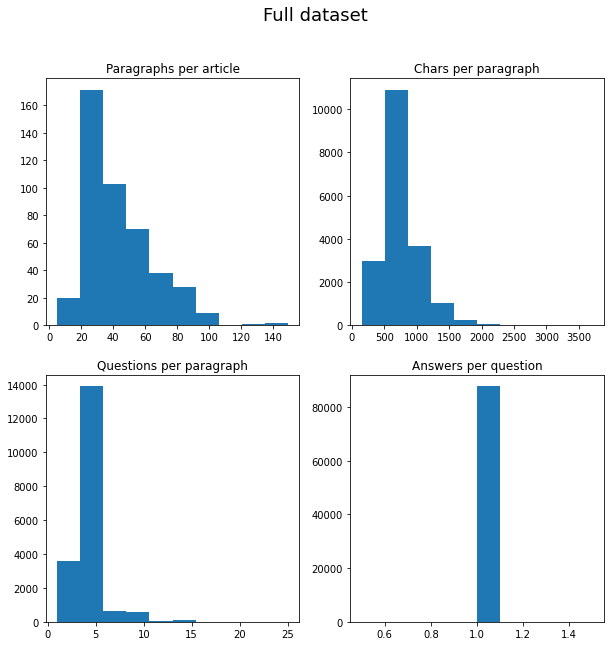

In [27]:
def get_stats(elemlist:List[float]):
    return  np.average(elemlist), np.max(elemlist),\
            np.min(elemlist), np.std(elemlist)

def plot_stats(elemlist:List[float], ax:plt.Axes, title:str):
    ax.hist(elemlist)
    ax.set_title(title)


def print_stats(dataset:Dict, title:str):
    print("The training set contains {} articles\n".format(len(dataset['data'])))
    paragraphs_len = [ len(article['paragraphs']) for article in dataset['data'] ]
    avg_paragraphs_len, max_paragraphs_len, min_paragraphs_len, std_paragraphs_len = \
        get_stats(paragraphs_len)
    print("On average, each articles contains {:.2f} paragraphs...".format(avg_paragraphs_len))
    print("\twith a maximum of {} paragraphs...".format(max_paragraphs_len))
    print("\tand a minimum of {} paragraphs...".format(std_paragraphs_len))
    print("\tand a standard deviation of {:.5f}.\n".format(std_paragraphs_len))

    contexts_len = [ len(paragraph['context']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs'] ]
    avg_context_len, max_context_len, min_context_len, std_context_len = \
        get_stats(contexts_len)
    print("On average, each paragraph is {:.2f} characters long...".format(avg_context_len))
    print("\twith a maximum of {} chars...".format(max_context_len))
    print("\tand a minimum of {} chars...".format(min_context_len))
    print("\tand a standard deviation of {:.5f}...".format(std_context_len))
    print("\tover a total of {} paragraphs.\n".format(len(contexts_len)))

    questions_len = [ len(paragraph['qas']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs'] ]
    avg_questions_len, max_questions_len, min_questions_len, std_questions_len = \
        get_stats(questions_len)
    print("On average, each paragraph contains {:.2f} questions...".format(avg_questions_len))
    print("\twith a maximum of {} questions...".format(max_questions_len))
    print("\tand a minimum of {} questions...".format(min_questions_len))
    print("\tand a standard deviation of {:.5f}.\n".format(std_questions_len))

    answers_len = [ len(question['answers']) for article in dataset['data'] 
                                            for paragraph in article['paragraphs']
                                            for question in paragraph['qas'] ]
    avg_answers_len, max_answers_len, min_answers_len, std_answers_len = \
        get_stats(answers_len)
    print("On average, each question has {:.2f} answers...".format(avg_answers_len))
    print("\twith a maximum of {} answers...".format(max_answers_len))
    print("\tand a minimum of {} answers...".format(min_answers_len))
    print("\tand a standard deviation of {:.5f}...".format(std_answers_len))
    print("\tover a total of {} questions.\n".format(len(answers_len)))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    fig.suptitle(title, fontsize=18)
    plot_stats(paragraphs_len, ax1, 'Paragraphs per article')
    plot_stats(contexts_len, ax2, 'Chars per paragraph')
    plot_stats(questions_len, ax3, 'Questions per paragraph')
    plot_stats(answers_len, ax4, 'Answers per question')

print_stats(questions, 'Full dataset')

We observe that on the training set there is only one answer for each question. On the tests set there could be multiple answers, but this should only be important when evaluating the model with the evaluation script.

### Dataset splitting

We can split the dataset into train and validation based on the articles' titles, so that questions related to one article are all either in the training or in the validation set.

We use a 75-25 train-val split and check that the two splits approximately have the same properties.

In [36]:
TRAIN_SPLIT_ELEM = int(len(questions['data']) / 100 * 75)
print("Using {} articles for validation and {} for training".format(
    len(questions['data']) - TRAIN_SPLIT_ELEM, TRAIN_SPLIT_ELEM)
)

data = random.sample(questions['data'], len(questions['data']))

Using 111 articles for validation and 331 for training


In [37]:
train_dataset = {'data': data[:TRAIN_SPLIT_ELEM]}
val_dataset = {'data': data[TRAIN_SPLIT_ELEM:]}

The training set contains 331 articles

On average, each articles contains 42.13 paragraphs...
	with a maximum of 149 paragraphs...
	and a minimum of 21.208461366316243 paragraphs...
	and a standard deviation of 21.20846.

On average, each paragraph is 741.83 characters long...
	with a maximum of 3706 chars...
	and a minimum of 151 chars...
	and a standard deviation of 310.23859...
	over a total of 13945 paragraphs.

On average, each paragraph contains 4.60 questions...
	with a maximum of 20 questions...
	and a minimum of 1 questions...
	and a standard deviation of 1.47449.

On average, each question has 1.00 answers...
	with a maximum of 1 answers...
	and a minimum of 1 answers...
	and a standard deviation of 0.00000...
	over a total of 64079 questions.



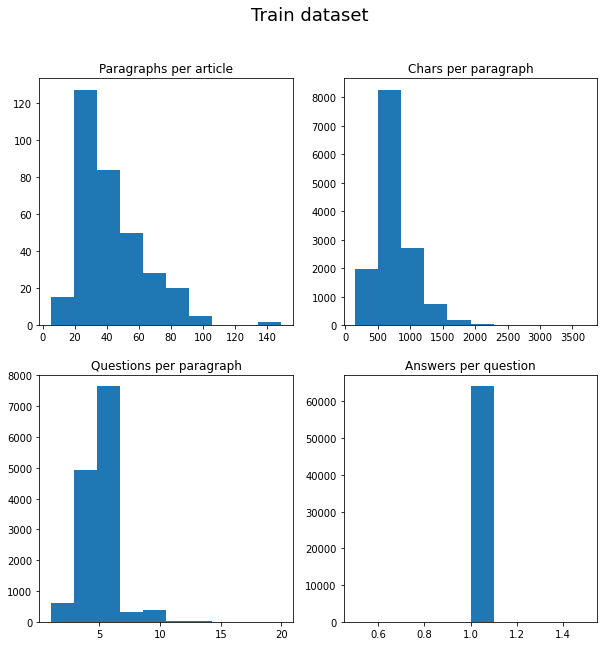

In [38]:
print_stats(train_dataset, 'Train dataset')

The training set contains 111 articles

On average, each articles contains 44.60 paragraphs...
	with a maximum of 127 paragraphs...
	and a minimum of 22.98267239154934 paragraphs...
	and a standard deviation of 22.98267.

On average, each paragraph is 718.75 characters long...
	with a maximum of 2508 chars...
	and a minimum of 151 chars...
	and a standard deviation of 308.55515...
	over a total of 4951 paragraphs.

On average, each paragraph contains 4.75 questions...
	with a maximum of 25 questions...
	and a minimum of 1 questions...
	and a standard deviation of 2.15474.

On average, each question has 1.00 answers...
	with a maximum of 1 answers...
	and a minimum of 1 answers...
	and a standard deviation of 0.00000...
	over a total of 23520 questions.



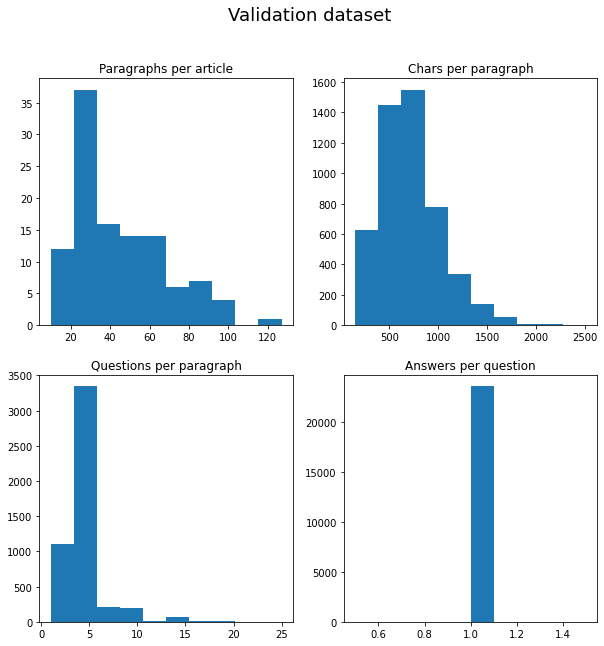

In [39]:
print_stats(val_dataset, 'Validation dataset')

The splitting was quite successful and both dataset splits have similar data distributions.